In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sp
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
import glob

%matplotlib inline

In [2]:
# Import behavior
folder = 'C:\\Users\\Sur lab\\Dropbox (MIT)\\trackball-behavior\\Data\\96\\Dec2018\\'
folder2 = 'C:\\Users\\Sur lab\\Dropbox (MIT)\\trackball-behavior\\Data\\96\\Oct2018\\'
folder3 = 'C:\\Users\\Sur lab\\Dropbox (MIT)\\trackball-behavior\\Data\\97\\Dec2018\\'

filename = '20181211_trackball_0096.mat'
#data = sp.loadmat(folder + filename)



In [3]:
def get_choice_stim(path):
    '''Given the path to the .mat behavior file,
    return the choice array and the stimulus type array'''
    data = sp.loadmat(path)
    choice = data['data']['response'][0,0]['choice'][0,0][0]
    ntrials = len(choice)
    stim = data['data']['stimuli'][0,0]['loc'][0,0][0][:ntrials]
    return choice, stim

In [4]:
def get_struct_field(data, field, subfield=None):
    if subfield == None:
        return data['data'][field][0,0]
    else:
        return data['data'][field][0,0][subfield][0,0][0]
def get_performance(data):
    '''Given the data structure, return the performance in the form:
    An N x 3 array where the columns correspond to
    contrast, performance left, performance right,
    and each column is one contrast'''
    # Load necessary arrays
    choice = data['data']['response'][0,0]['choice'][0,0][0]
    ntrials = len(choice)
    stim = data['data']['stimuli'][0,0]['loc'][0,0][0][:ntrials]
    cons = data['data']['stimuli'][0,0]['opp_contrast'][0,0][0][:ntrials]

    # Process
    curr_con = np.unique(cons)
    output = np.zeros((len(curr_con), 3))
    for i in range(len(curr_con)):
        if np.sum((stim == 2) & (cons == curr_con[i])) == np.sum((stim == 2) & (cons == curr_con[i]) & (choice == 5)):
            perf_l = np.nan
        else:
            perf_l = float(np.sum((stim == 2) & (choice == 2) & (cons == curr_con[i]))) / \
                (np.sum((stim == 2) & (cons == curr_con[i])) - np.sum((stim == 2) & (cons == curr_con[i]) & (choice == 5)))
        #print np.sum((stim == 2) & (choice == 2) & (cons == curr_con[i]))
        if np.sum((stim == 1) & (cons == curr_con[i])) == np.sum((stim == 1) & (cons == curr_con[i]) & (choice == 5)):
            perf_r = np.nan
        else:
            perf_r = float(np.sum((stim == 1) & (choice == 1) & (cons == curr_con[i]))) / \
                (np.sum((stim == 1) & (cons == curr_con[i])) - np.sum((stim == 1) & (cons == curr_con[i]) & (choice == 5)))
        
        output[i,0] = curr_con[i]
        output[i,1] = perf_l
        output[i,2] = perf_r
    return output

def plot_psychometric(data):
    '''Given the data structure, plot the psychometric curve'''
    performance = get_performance(data)
    contrast = get_struct_field(data, 'params', 'contrast')
    condiff = performance[:,0] - contrast
    xaxis = np.hstack([condiff, -np.flip(condiff, axis=0)])
    yaxis = np.hstack([1 - performance[:,2], np.flip(performance[:,1], axis=0)])
    #print(xaxis)
    plt.plot(xaxis, yaxis, 'b', alpha=0.1)
    plt.xlabel('Contrast difference')
    plt.ylabel('% Left')
    plt.ylim([0, 1])
    

## Define new classes for easy data analysis

In [5]:
def get_struct_field(data, field, subfield=None):
    if subfield == None:
        return data['data'][field][0,0]
    else:
        return data['data'][field][0,0][subfield][0,0][0]

class Session(object):
    def __init__(self, folder, filename):
        self.data = sp.loadmat(folder + filename)
        self.mouse = get_struct_field(self.data, 'mouse')[0,0]
        self.choice = get_struct_field(self.data, 'response', 'choice')
        self.ntrials = len(self.choice)
        self.stim = get_struct_field(self.data, 'stimuli', 'loc')[:self.ntrials]
        self.cons = get_struct_field(self.data, 'stimuli', 'opp_contrast')[:self.ntrials]
        
    def get_choice(self):
        '''Returns an array of choice'''
        return self.choice
    
    def get_stim(self):
        '''Returns an array of stimulus location'''
        return self.stim
        
    def get_opp_contrast(self):
        '''Returns an array of opposite contrast'''
        return self.cons
    
    def get_performance(self):
        '''Given the data structure, return the performance in the form:
        An N x 3 array where the columns correspond to
        contrast, performance left, performance right,
        and each column is one contrast'''
        # Load necessary arrays
        choice = self.get_choice()  
        stim = self.get_stim()
        cons = self.get_opp_contrast()

        # Process
        curr_con = np.unique(cons)
        output = np.zeros((len(curr_con), 3))
        for i in range(len(curr_con)):
            if np.sum((stim == 2) & (cons == curr_con[i])) == np.sum((stim == 2) & (cons == curr_con[i]) & (choice == 5)):
                perf_l = np.nan
            else:
                perf_l = float(np.sum((stim == 2) & (choice == 2) & (cons == curr_con[i]))) / \
                    (np.sum((stim == 2) & (cons == curr_con[i])) - np.sum((stim == 2) & (cons == curr_con[i]) & (choice == 5)))
            #print np.sum((stim == 2) & (choice == 2) & (cons == curr_con[i]))
            if np.sum((stim == 1) & (cons == curr_con[i])) == np.sum((stim == 1) & (cons == curr_con[i]) & (choice == 5)):
                perf_r = np.nan
            else:
                perf_r = float(np.sum((stim == 1) & (choice == 1) & (cons == curr_con[i]))) / \
                    (np.sum((stim == 1) & (cons == curr_con[i])) - np.sum((stim == 1) & (cons == curr_con[i]) & (choice == 5)))

            output[i,0] = curr_con[i]
            output[i,1] = perf_l
            output[i,2] = perf_r
        return output
    
    def plot_raw_performance(self):
        '''Plot a visualization of raw performance'''
        choice = self.get_choice()
        ntrials = self.ntrials
        stim = self.get_stim()
        trialstart = get_struct_field(self.data, 'response', 'trialstart') / 60
        
        # Plot the time-outs
        timeouts = np.where(choice == 5)
        plt.figure(figsize=(20, 10))
        plt.plot(trialstart[timeouts], stim[timeouts], 'ko')
        
        # Plot correct/incorrect trials
        corr = np.where((choice != 5) & (stim == choice))[0]
        incorr = np.where((choice != 5) & (stim != choice))[0] 
        plt.plot(trialstart[corr], stim[corr], 'bo')
        plt.plot(trialstart[incorr], stim[incorr], 'ro')
        
        plt.xlabel('Time (min)')
        plt.yticks([1, 2], ['Left', 'Right'])
        

    def plot_psychometric(self):
        '''Given the data structure, plot the psychometric curve'''
        performance = self.get_performance()
        contrast = get_struct_field(self.data, 'params', 'contrast')
        condiff = performance[:,0] - contrast
        xaxis = np.hstack([condiff, -np.flip(condiff, axis=0)])
        yaxis = np.hstack([1 - performance[:,2], np.flip(performance[:,1], axis=0)])
        #print(xaxis)
        plt.plot(xaxis, yaxis, 'b', alpha=0.1)
        plt.xlabel('Contrast difference')
        plt.ylabel('% Left')
        plt.ylim([0, 1])
        
    def find_logistic_coef(self):
        '''Returns the logistic regression of the session'''
        choice = self.get_choice()
        stim = self.get_stim()
        
        #timeouts = np.where(choice == 5)
        #corr = np.where((choice != 5) & (stim == choice))
        #incorr = np.where((choice != 5) & (stim != choice))
        #left = np.where(stim == 1)
        #right = np.where(stim == 2)

        # Make a design matrix
        currchoice = choice[1:]
        currstim = stim[1:]
        prevchoice = choice[:-1]
        prevstim = stim[:-1]
        prev_reward = prevchoice * prevstim
        prev_choiceXrew = prevchoice * prev_reward

        y_b = currchoice[(currchoice != 5) & (prevchoice != 5)] - 1
        X = np.vstack([currstim, prev_reward, prevchoice, prev_reward, prev_choiceXrew]).T
        X_b = X[(currchoice != 5) & (prevchoice != 5),:] - 1

        if len(np.unique(y_b)) < 2:
            raise ValueError('Only one value in y')
        # Do logistic regression
        clf = LogisticRegression(random_state=0, solver='lbfgs',
                                  multi_class='multinomial').fit(X_b, y_b)

        # Print the coefficients
        return clf.coef_, clf.intercept_
        
    

In [6]:
session1 = Session(folder, filename)

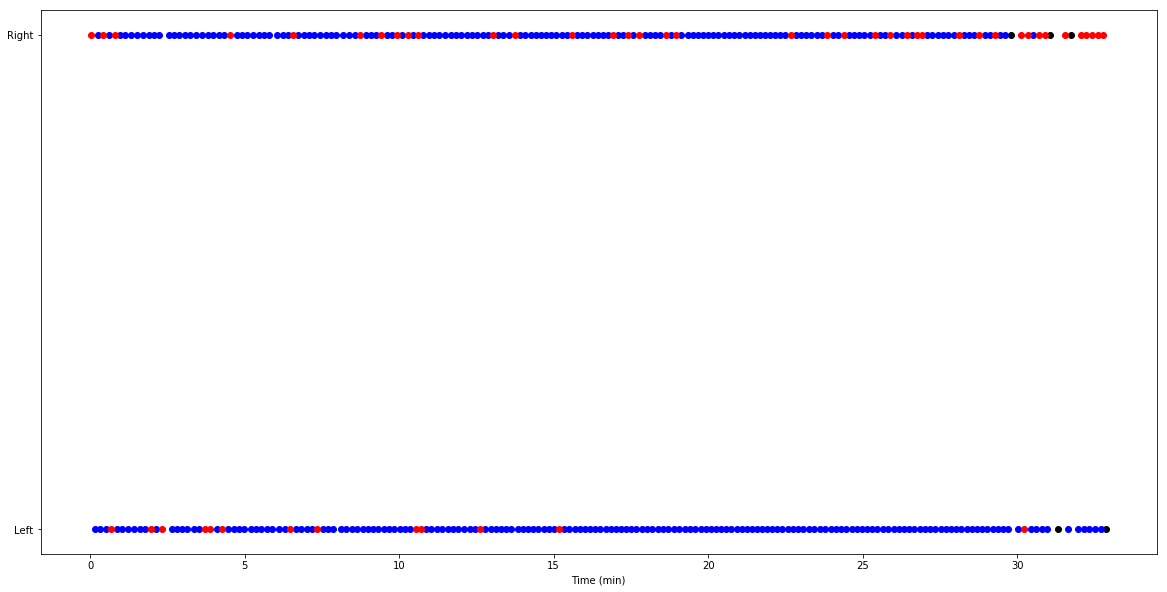

In [7]:
session1.plot_raw_performance()

In [8]:
session1.find_logistic_coef()

(array([[ 1.03473932, -0.56567345, -0.11402591, -0.56567345,  0.37176831]]),
 array([-0.36614981]))

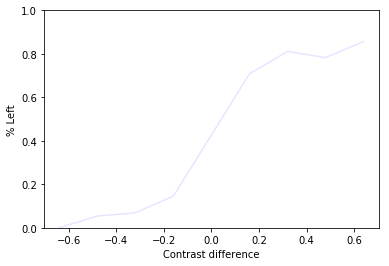

In [9]:
session1.plot_psychometric()